In [1]:
import pathlib
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import h5py
import pandas as pd

from astropy.io.votable import parse

%matplotlib inline

In [ ]:
'''def votable_to_pandas(votable_file):
    votable = parse(votable_file)
    table = votable.get_first_table().to_table(use_names_over_ids=True)
    return table.to_pandas()

gaia_data = votable_to_pandas('files/gaiaDR3_06092025_votable.vot')
print(gaia_data)'''

In [ ]:
# subset of data to work with for now
gaia_data = pd.read_csv('files/gaiaDR3_05292025.csv',index_col=False)
print(len(gaia_data))

3000000


768


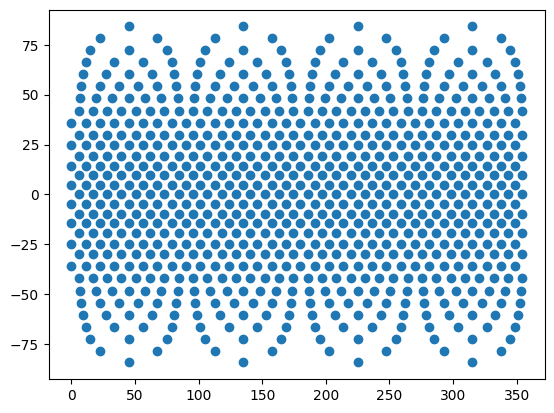

In [3]:
level = 3
nside = hp.order2nside(level)
pix_ctr = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)), lonlat=True)
print(hp.nside2npix(nside))

plt.scatter(pix_ctr[0], pix_ctr[1])

In [ ]:
# just solar twins for now

gaia_data['Gmag'] = gaia_data['phot_g_mean_mag']-5*np.log10(1/(gaia_data['parallax']*1e-3))+5

gaia_data = gaia_data[np.isfinite(gaia_data['phot_bp_mean_mag']) & \
            np.isfinite(gaia_data['phot_rp_mean_mag']) & np.isfinite(gaia_data['Gmag'])]


# solar twin cuts from https://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt
solar_twins = gaia_data[(np.abs(gaia_data['phot_bp_mean_mag']-gaia_data['phot_rp_mean_mag']) < 0.832) & \
            (np.abs(gaia_data['phot_bp_mean_mag']-gaia_data['phot_rp_mean_mag']) > 0.803) & \
            (gaia_data['Gmag'] > 4.462) & (gaia_data['Gmag'] < 4.703)]

print(len(gaia_data))
print(len(solar_twins))

2918765
3730


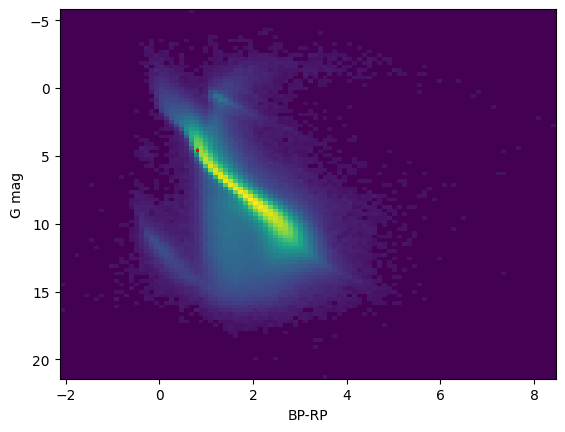

In [10]:
import matplotlib.colors as mcolors

plt.hist2d(gaia_data['phot_bp_mean_mag']-gaia_data['phot_rp_mean_mag'],gaia_data['Gmag'],bins=100,\
           norm=mcolors.PowerNorm(0.3))
plt.vlines(x=0.803,ymin=4.462,ymax=4.703,color='r')
plt.vlines(x=0.832,ymin=4.462,ymax=4.703,color='r')
plt.hlines(y=4.703,xmin=0.803,xmax=0.832,color='r')
plt.hlines(y=4.462,xmin=0.803,xmax=0.832,color='r')
plt.gca().invert_yaxis()
plt.xlabel(r'BP-RP')
plt.ylabel(r'G mag')
plt.show()

In [8]:
# pre-compute healpix pixels for all stars at a given healpix level
nside = hp.order2nside(level)
gaia_data["hp_pix_"+str(level)] = (gaia_data["source_id"] / (2**35 * 4**(12-level))).astype(int)

In [59]:
# convert mas/yr * pc to km/s
pc_mas_yr_per_km_s = (1*u.km/u.s).to(u.pc*u.mas/u.yr, u.dimensionless_angles()).value
km_s_per_pc_mas_yr = 1/pc_mas_yr_per_km_s

def prelim_cuts(plx1,plx2,e_plx1,e_plx2,pmra1,pmra2,pmdec1,pmdec2):
    # cut 1: diff in plx < sqrt((1 pc converted to mas)**2 + n**2 * (e_plx1**2 + e_plx2**2))
    n = 3 # sigma - try 3 or 8
    quantity1 = np.sqrt(1e3**2 + n**2 * (e_plx1**2 + e_plx2**2)) 

    # cut 2: diff in tang. vel < 20 km/s
    tang_vel_diff = np.sqrt(((1e3*plx1**-1)*pmra1-(1e3*plx2**-1)*pmra2)**2 + ((1e3*plx1**-1)*pmdec1-(1e3*plx2**-1)*pmdec2)**2) # Oh+17, Eq. 2
    tang_vel_diff_kms = tang_vel_diff*km_s_per_pc_mas_yr # convert to km/s

    return (np.abs(plx1-plx2) < quantity1) & (tang_vel_diff_kms < 20)

In [ ]:
solar_twins = solar_twins.reset_index(drop=True)

other_idx_final=[]
for i,row in solar_twins.iterrows():
    this_pix = row["hp_pix_"+str(level)]
    other_pix = hp.get_all_neighbours(nside, this_pix, nest=True)

    other_star_idx = np.where(gaia_data["hp_pix_"+str(level)].isin(other_pix))[0]
    other_stars = gaia_data.iloc[other_star_idx]

    # TODO: pass stuff to prelim_cuts
    prelim_mask = prelim_cuts(solar_twins['parallax'].iloc[i],other_stars['parallax'],solar_twins['parallax_error'].iloc[i],\
                            other_stars['parallax_error'],solar_twins['pmra'].iloc[i],other_stars['pmra'],\
                            solar_twins['pmdec'].iloc[i],other_stars['pmdec'])
    
    if prelim_mask.sum() == 0:
        continue

    other_star_idx_passed = other_star_idx[prelim_mask]
    other_idx_final.append(other_star_idx_passed)


# TODO: store mapping from i (in FGK_dwarfs) to array other_parent_idx - done, I think

    
    '''mask = np.isin(
        gaia_data["hp_pix_"+str(level)], np.concatenate((this_pix, other_pix))
    )
    subset = gaia_data[mask]

    # TODO: compute sky separation, El-Badry criteria (loosened), ∆G, ∆G-RP
    print(len(gaia_data), len(subset))'''

123995
3524
123995
30591
123995
11478
123995
13592
110438
32891
123995
25914
123995
8888
110438
17197
123995
15089
123995
7103
110438
15071
123995
496
123995
10197
123995
1286
123995
16839
110438
21844
123995
1110
123995
13808
110438
16433
123995
26749
176208
13964
123995
9788
110438
8887
123995
17366
123995
3968
110438
27894
110438
27928
110438
35452
123995
32217
123995
29312
110438
18109
123995
10883
123995
31713
123995
28257
123995
18520
110438
45135
123995
13855
123995
6043
123995
32878
110438
31809
123995
12928
123995
23721
110438
9493
176208
38457
123995
6077
110438
6819
110438
33433
123995
5477
123995
1250
123995
8911
123995
9398
123995
11737
110438
46859
110438
30379
123995
10524
123995
13795
123995
25313
110438
19695
123995
3971
176208
1097
110438
31751
110438
35480
110438
34962
123995
7995
123995
15868
123995
7273
123995
2509
123995
12597
123995
25699
123995
23436
110438
6195
123995
15059
110438
28425
110438
11417
123995
28427
123995
26159
123995
5546
123995
11703
123995
1548

KeyboardInterrupt: 

In [115]:
np.sqrt(hp.nside2pixarea(nside, degrees=True)) / np.pi

np.float64(2.33290514929399)

In [116]:
(4 * u.pc / (50 * u.pc)).to(u.deg, equivalencies=u.dimensionless_angles())

<Quantity 4.58366236 deg>

In [15]:
with h5py.File(files[0], "r") as f:
    ra = f["ra"][:]
    dec = f["dec"][:]
    print(f.keys())

<KeysViewHDF5 ['ag_gspphot', 'ag_gspphot_lower', 'ag_gspphot_upper', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_gof_al', 'astrometric_matched_transits', 'astrometric_n_bad_obs_al', 'astrometric_n_good_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_obs_al', 'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_sigma5d_max', 'azero_gspphot', 'azero_gspphot_lower', 'azero_gspphot_upper', 'b', 'bp_g', 'bp_rp', 'classprob_dsc_combmod_galaxy', 'classprob_dsc_combmod_quasar', 'classprob_dsc_combmod_star', 'dec', 'dec_error', 'dec_parallax_corr', 'dec_pmdec_corr', 'dec_pmra_corr', 'dec_pseudocolour_corr', 'distance_gspphot', 'distance_gspphot_lower', 'distance_gspphot_upper', 'duplicated_source', 'ebpminrp_gspphot', 'ebpminrp_gspphot_lower', 'ebpminrp_gspphot_upper', 'ecl_lat', 'ecl_lon', 'g_rp', 'grvs_mag', 'grvs_mag_error', 'grvs_mag_nb_transits', 'has_epoch_photometry', 'has_epoch_rv', 'has_mcmc_gspphot', 'has_mcmc_msc', 

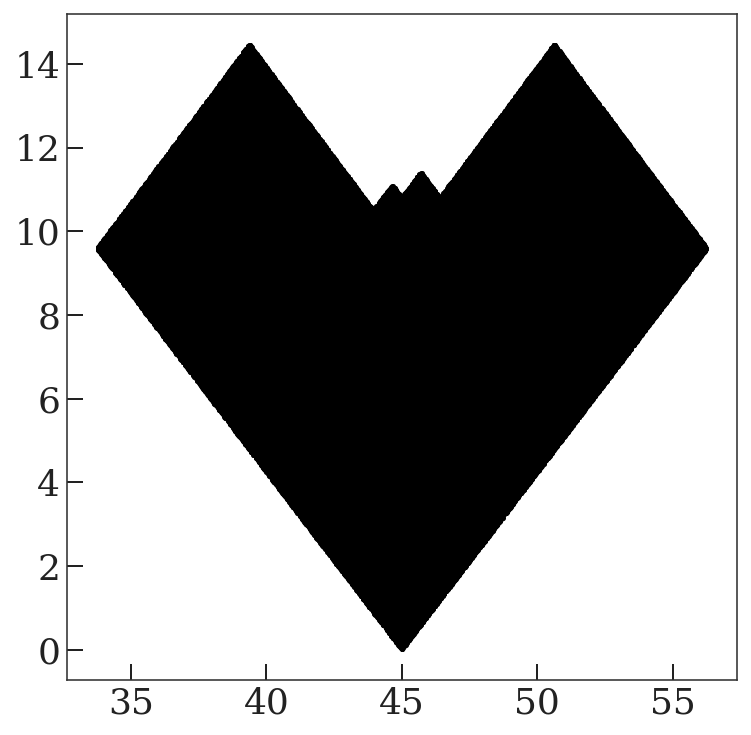

In [16]:
plt.plot(ra, dec, "k.")